<a href="https://colab.research.google.com/github/wonjongbot/AlexNet/blob/main/AlexNet_reimplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Assignment!
1. VOC Dataset
2. Training & Testing Functions
3. Train!
4. Build AlexNet
5. Build your own Neural Network Architecture!

## Import modules

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("gdrive/My Drive/pytorch_assignment")

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision

from torchvision import transforms
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from voc_dataloader import VocDataset, VOC_CLASSES

%matplotlib inline
%load_ext autoreload
%autoreload 2

## VOC Dataset Download

In [ ]:
!sh download_data.sh

import shutil 
shutil.copyfile("VOCtrainval_06-Nov-2007.tar", "/content/VOCtrainval_06-Nov-2007.tar")
!tar -xf "/content/VOCtrainval_06-Nov-2007.tar" -C "/content/" 
shutil.move("/content/VOCdevkit/", "/content/VOCdevkit_2007")

shutil.copyfile("VOCtest_06-Nov-2007.tar", "/content/VOCtest_06-Nov-2007.tar")
!tar -xf "/content/VOCtest_06-Nov-2007.tar" -C "/content/" 
shutil.move("/content/VOCdevkit/VOC2007", "/content/VOCdevkit_2007/VOC2007test")

--2022-05-25 22:20:21--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar.6’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  68.3MB/s    in 7.0s    

2022-05-25 22:20:28 (62.2 MB/s) - ‘VOCtrainval_06-Nov-2007.tar.6’ saved [460032000/460032000]

--2022-05-25 22:21:48--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar.4’

VOCtest_06-Nov-2007 100%[=============

'/content/VOCdevkit_2007/VOC2007test'

### VOC Dataset 


*   Train set
*   Validation set
*   Test set



#### Transformation (If wanted you can add more data transformation to train set)

In [ ]:
# Transforms applied to the training data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize
        ])

# Transforms applied to the testing data
test_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize,
        ])

In [ ]:
os.chdir('/content')
!pwd
!ls

/content
gdrive	     VOCdevkit	     VOCtest_06-Nov-2007.tar
sample_data  VOCdevkit_2007  VOCtrainval_06-Nov-2007.tar


In [ ]:

ds_train = VocDataset('VOCdevkit_2007/VOC2007','train',train_transform)
ds_val = VocDataset('VOCdevkit_2007/VOC2007','val',test_transform)
ds_test = VocDataset('VOCdevkit_2007/VOC2007test','test', test_transform)

/content/gdrive/MyDrive/pytorch_assignment/voc_dataloader.py:137: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(box_indices),


### Visualization of data sample
Some example images of the data.

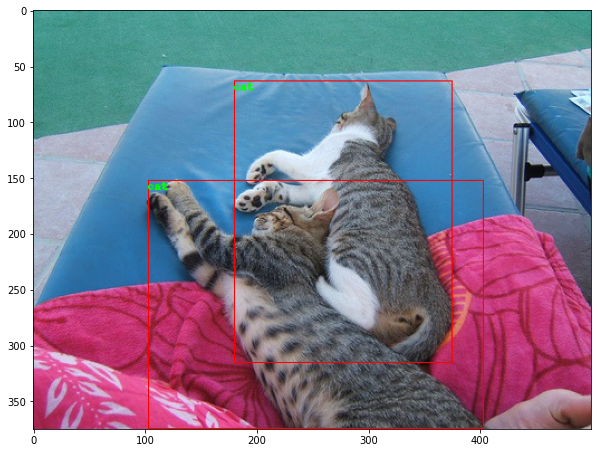

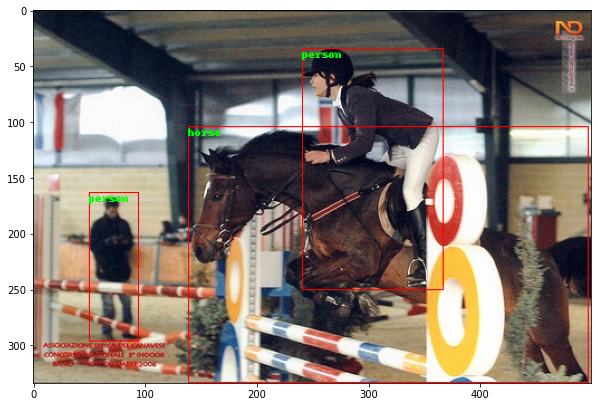

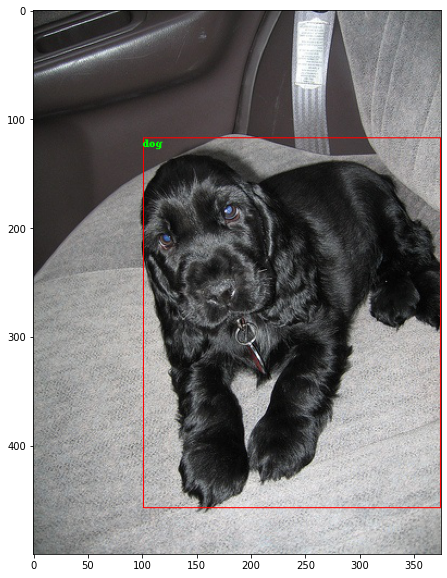

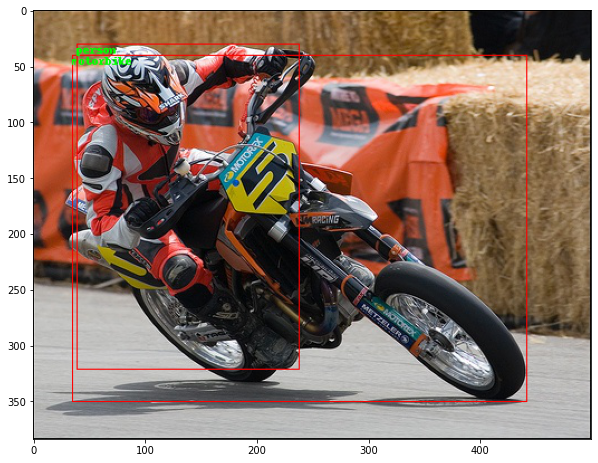

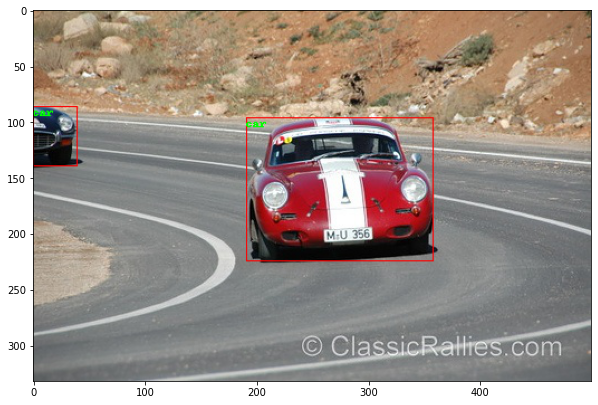

In [ ]:
for i in range(5):
    idx = np.random.randint(0, len(ds_train.names)+1)
    _imgpath = os.path.join('/content/VOCdevkit_2007/VOC2007/', 'JPEGImages', ds_train.names[idx]+'.jpg')
    img = Image.open(_imgpath).convert('RGB')
    draw = ImageDraw.Draw(img)
    for j in range(len(ds_train.box_indices[idx])):
        obj = ds_train.box_indices[idx][j]
        draw.rectangle(list(obj), outline=(255,0,0))
        draw.text(list(obj[0:2]), ds_train.classes[ds_train.label_order[idx][j]], fill=(0,255,0))
    plt.figure(figsize = (10,10))
    plt.imshow(np.array(img))

### VOC DataLoader
  * Train DataLoader
  * Test Dataset

In [ ]:
# Hyperparameters 다른 값으로 실험해보세요!
BATCH_SIZE = 32

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               num_workers=1)

In [ ]:
val_loader = torch.utils.data.DataLoader(dataset=ds_val,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               num_workers=1)

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=50, 
                                               shuffle=False,
                                               num_workers=1)

## Training & Testing Functions

### Train funtion


In [ ]:
#TODO: include device in parameters
device = torch.device("cuda")

In [ ]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

### Test function

In [ ]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True, print_total=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0,21))
        y_score = np.zeros((0,21))
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss.item())
        aps = []
        # ignore first class which is background
        for i in range(1, y_true.shape[1]):
            ap = average_precision_score(y_true[:, i], y_score[:, i])
            if print_ind_classes:
                print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VOC_CLASSES[i], ap))
            aps.append(ap)
        
        mAP = np.mean(aps)
        test_loss = np.mean(losses)
        if print_total:
            print('mAP: {0:.4f}'.format(mAP))
            print('Avg loss: {}'.format(test_loss))
        
    return mAP, test_loss, aps

### Plot progress

In [ ]:
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
def plot_mAP(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("mAP Plot")
    plt.ylabel("mAP")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

### Train network

In [ ]:
import time 

def train(classifier, num_epochs, train_loader,val_loader, criterion, optimizer, test_frequency=5):
    train_losses = []
    train_mAPs = []
    val_losses = []
    val_mAPs = []

    for epoch in range(1,num_epochs+1):
        since = time.time()
        print("Starting epoch number " + str(epoch))
        train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
        train_losses.append(train_loss)
        print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
        if(epoch%test_frequency==0 or epoch==1):
            mAP_train, _, _ = test_classifier(train_loader, classifier, criterion, False, False)
            train_mAPs.append(mAP_train)
            mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
            print('Evaluating classifier')
            print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
            val_losses.append(val_loss)
            val_mAPs.append(mAP_val)
        time_elapsed = time.time() - since
        print('Epcoh complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    
    return classifier, train_losses, val_losses, train_mAPs, val_mAPs

## Build AlexNet (TODO)

https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

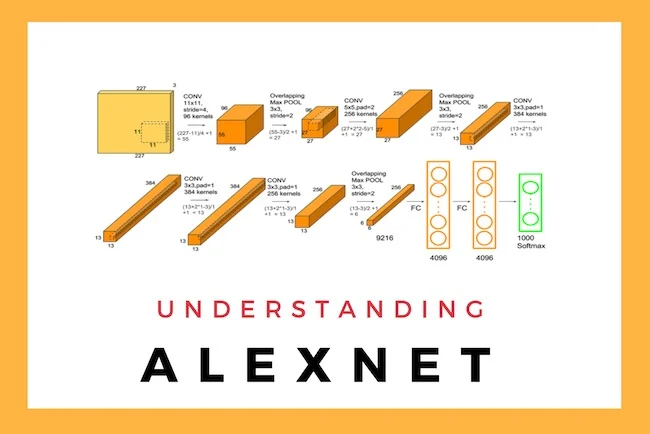

In [ ]:
class AlexNet_(nn.Module):
    def __init__(self, num_classes: int = 21, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Build your own Neural Network Architecture!

In [ ]:
#TODO

### What is your Neural Network? 

At first, use the alexnet as you "classifier" and then design and build or build one from another source of paper as you "classifier"!

In [ ]:
classifier = AlexNet_()
classifier = classifier.to(device)

## Train!

In [ ]:
# Hyperparameters 이것도 실험해보세요!
LR = 1e-4 #1e-4 previously
NUM_EPOCHS = 20
TEST_FREQUENCY = 5

In [ ]:
criterion = nn.MultiLabelSoftMarginLoss() # 바꾸셔도 됩니다.
optimizer = torch.optim.Adam(classifier.parameters(), lr=LR) # 바꾸셔도 됩니다.
classifier, train_losses, val_losses, train_mAPs, val_mAPs = train(
    classifier,
    NUM_EPOCHS,
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    TEST_FREQUENCY)

Starting epoch number 1
Loss for Training on Epoch 1 is 0.2736992835998535
-------  Class: aeroplane        AP:   0.0848  -------
-------  Class: bicycle          AP:   0.0476  -------
-------  Class: bird             AP:   0.1194  -------
-------  Class: boat             AP:   0.0919  -------
-------  Class: bottle           AP:   0.0420  -------
-------  Class: bus              AP:   0.0287  -------
-------  Class: car              AP:   0.1108  -------
-------  Class: cat              AP:   0.0901  -------
-------  Class: chair            AP:   0.1201  -------
-------  Class: cow              AP:   0.0342  -------
-------  Class: diningtable      AP:   0.0537  -------
-------  Class: dog              AP:   0.1180  -------
-------  Class: horse            AP:   0.0510  -------
-------  Class: motorbike        AP:   0.0409  -------
-------  Class: person           AP:   0.3777  -------
-------  Class: pottedplant      AP:   0.0479  -------
-------  Class: sheep            AP:   0.0376

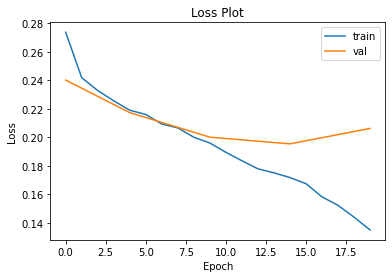

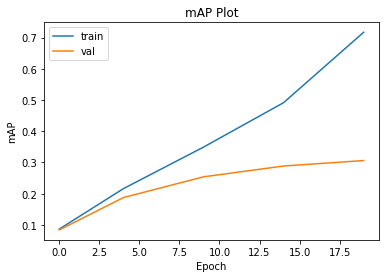

In [ ]:
# Compare train and validation metrics
plot_losses(train_losses, val_losses, TEST_FREQUENCY, NUM_EPOCHS)
plot_mAP(train_mAPs, val_mAPs, TEST_FREQUENCY, NUM_EPOCHS)

In [ ]:
# Save the clssifier network
# Suggestion: you can save checkpoints of your network during training and reload them later
torch.save(classifier.state_dict(), './voc_simple_classifier.pth')

## Test

In [ ]:
mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)

-------  Class: aeroplane        AP:   0.5838  -------
-------  Class: bicycle          AP:   0.3188  -------
-------  Class: bird             AP:   0.1850  -------
-------  Class: boat             AP:   0.2781  -------
-------  Class: bottle           AP:   0.1636  -------
-------  Class: bus              AP:   0.1634  -------
-------  Class: car              AP:   0.5641  -------
-------  Class: cat              AP:   0.2670  -------
-------  Class: chair            AP:   0.3212  -------
-------  Class: cow              AP:   0.1445  -------
-------  Class: diningtable      AP:   0.2726  -------
-------  Class: dog              AP:   0.2162  -------
-------  Class: horse            AP:   0.5707  -------
-------  Class: motorbike        AP:   0.3191  -------
-------  Class: person           AP:   0.7042  -------
-------  Class: pottedplant      AP:   0.1584  -------
-------  Class: sheep            AP:   0.1992  -------
-------  Class: sofa             AP:   0.2470  -------
-------  C

In [ ]:
mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)

-------  Class: aeroplane        AP:   0.5333  -------
-------  Class: bicycle          AP:   0.2683  -------
-------  Class: bird             AP:   0.1806  -------
-------  Class: boat             AP:   0.2708  -------
-------  Class: bottle           AP:   0.1163  -------
-------  Class: bus              AP:   0.1950  -------
-------  Class: car              AP:   0.5464  -------
-------  Class: cat              AP:   0.2293  -------
-------  Class: chair            AP:   0.2884  -------
-------  Class: cow              AP:   0.1180  -------
-------  Class: diningtable      AP:   0.2627  -------
-------  Class: dog              AP:   0.1516  -------
-------  Class: horse            AP:   0.5105  -------
-------  Class: motorbike        AP:   0.3220  -------
-------  Class: person           AP:   0.6847  -------
-------  Class: pottedplant      AP:   0.1179  -------
-------  Class: sheep            AP:   0.1422  -------
-------  Class: sofa             AP:   0.2173  -------
-------  C